# Collimated data reduction for OFFSPEC

[OFFSPEC](https://www.isis.stfc.ac.uk/Pages/Offspec.aspx) is a reflectometry instrument at the ISIS Neutron and Muon Source, which can measure reflectometry with a collimated beam. 
In this notebook, we will look at reducing data from the OFFSPEC reflectometer, with the aim of reproducing reduction from the [mantid reduction software](https://docs.mantidproject.org/nightly/algorithms/ReflectometryReductionOne-v2.html)
This is a living document and there are plans to update this as necessary with changes in the data reduction methodology and code.
We thank Jos Cooper (ISIS Neutron and Muon Source) for sharing the data used in this notebook and for insight into the reduction process.

First, we import the necessary modules for this notebook. 

In [1]:
import scipp as sc
import scippneutron as scn
import plopp as pp
from ess import amor, reflectometry
import numpy as np
import ess

pp.patch_scipp()

In [2]:
logger = ess.logging.configure_workflow('offspec_reduction',
                                        filename='offspec.log')

## The OFFSPEC beamline

At the OFFSPEC instrument, a collimated beam of neutrons is incident on the sample at a grazing angle. 
These neutrons are reflected through the specular condition, that is the angle of incidence is equal to the angle of reflection. 
The neutrons are then detected at the detector (this is shown diagramtically below). 

[ TODO: Insert diagram here ]

## Setting the experiment metadata

For writing reduced data files, we will use the [orso reflectometry standard](https://www.reflectometry.org/file_format/specification), which we can achieve using the [orsopy](https://orsopy.readthedocs.io/en/latest/) Python package.
The orsopy object is also important for storing relevant metadata to be written in the reduced file. 

In [3]:
from orsopy import fileio
from ess.amor.orso import make_orso

owner = fileio.base.Person('Jos Cooper', 'ISIS Neutron and Muon Source', 'jos.cooper@stfc.ac.uk')
sample = fileio.data_source.Sample('Fringy ', 'gas/solid', 'air | (Ni | Ti) * 5 | Si')
creator = fileio.base.Person('Andrew R. McCluskey', 'European Spallation Source', 'andrew.mccluskey@ess.eu')

orso = make_orso(owner=owner,
                 sample=sample,
                 creator=creator,
                 reduction_script='https://github.com/scipp/ess/blob/main/docs/instruments/external/offspec/offspec_collimated.ipynb')

## Loading the data

The sample measurement has been saved in the `sample.nxs` file, while the `direct_beam.nxs` file contains data from the direct beam, achieved by positioning the detector directly in the beam of incident neutrons and moving the sample out of the way. 
The direct beam measurement gives an estimate for the ISIS pulse structure as a function of time-of-flight. 
We load these files below. 

In [4]:
# TODO: Replace with pooch loading and the reflectometry loader?

sample = scn.load("../../../../data/sample.nxs", mantid_args={"LoadMonitors": True})
direct_beam = scn.load("../../../../data/direct_beam.nxs", mantid_args={"LoadMonitors": True})
sample.attrs['orso'] = sc.scalar(orso)
direct_beam.attrs['orso'] = sc.scalar(orso)

Workspace run log 'good_frames' has unrecognised units: 'frames'
Workspace run log 'period_change_log' has unrecognised units: 'period_number'
Workspace run log 'raw_frames' has unrecognised units: 'frames'
Workspace run log 'veto_log' has unrecognised units: 'is_vetoing'
Workspace run log 'events_log' has unrecognised units: 'events'
Workspace run log 'frame_log' has unrecognised units: 'frame_number'
Workspace run log 'good_frame_log' has unrecognised units: 'is_good'
Workspace run log 'period_log' has unrecognised units: 'period_number'
Workspace run log 'raw_events_log' has unrecognised units: 'events'
Workspace run log 'good_frames' has unrecognised units: 'frames'
Workspace run log 'period_change_log' has unrecognised units: 'period_number'
Workspace run log 'raw_frames' has unrecognised units: 'frames'
Workspace run log 'veto_log' has unrecognised units: 'is_vetoing'
Workspace run log 'events_log' has unrecognised units: 'events'
Workspace run log 'frame_log' has unrecognised un

### Correcting the position of detector pixels

The pixel positions in `sample.nxs` must be modified to account for the transformation on the detector by moving it up. 
We can achieve this by understanding that the sample has been rotated by some amount (as discussed above) and that sample measurment has the specular peak at the same pixel as the direct beam measurement has the direct beam. 
Therefore, we move the sample detector up by the tangent of $2\omega$ (in the OFFSPEC files, $\omega$ is called `'Theta'`). 

In [5]:
logger.info("Correcting pixel positions in 'sample.nxs'")
def pixel_position_correction(data: sc.DataArray):
    return (data.coords['position'] - data.coords['sample_position']).fields.z * sc.tan(2.0 * data.attrs['Theta'].value.data[-1])

sample.coords['position'].fields.y += pixel_position_correction(sample)
sample.attrs['orso'].value.data_source.measurement.comment = 'Pixel positions corrected'

We can visualise the data with a plot. 
In this plot, which comes from the sample, we can see the specular intensity at around spectrum numbers 400-410. 
There is a more intense region, closer to spectrum number 300, which comes from the direct beam of neutrons travelling straight through our sample. 

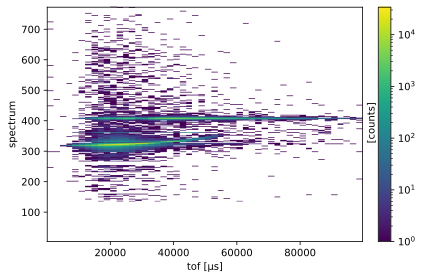

In [6]:
sample.hist(tof=50).plot(norm='log')

## Coordinate transform graph

To compute the wavelength $\lambda$, the scattering angle $\theta$, and the $Q$ vector for our data we can use a coordinate transform graph. 
The reflectometry graph is discussed in detail in the [Amor reduction notebook](https://scipp.github.io/ess/instruments/amor/amor_reduction.html) and the one used here is nearly identical.
The only difference is the Amor instrument uses choppers to define the pulse of neutrons, which is not the case here. 
The OFFSPEC graph is the standard reflectometry graph, shown below. 

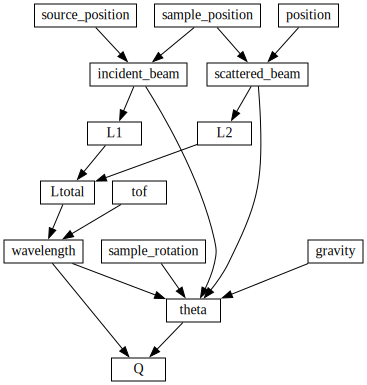

In [7]:
graph = {**reflectometry.conversions.specular_reflection()}
sc.show_graph(graph, simplified=True)

## Computing the wavelength

The neutron wavelengths can be computed with `transform_coords` and the graph shown above. 
We will only use neutron was a wavelength range of 1.5 Å to 12.0 Å. 

In [8]:
wavelength_edges = sc.array(dims=['wavelength'], 
                            values=[1.5, 12], 
                            unit='angstrom')
sample_wav = reflectometry.conversions.tof_to_wavelength(sample, wavelength_edges, graph=graph)

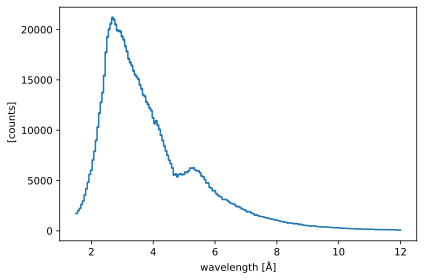

In [9]:
sample_wav.bins.concat('spectrum').hist(wavelength=200).plot()

For the direct beam, we use a non-scattering graph, shown below. 

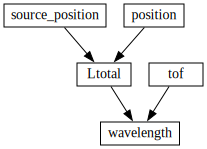

In [10]:
no_scatter_graph = {**scn.conversion.graph.beamline.beamline(scatter=False),
                    **scn.conversion.graph.tof.elastic_wavelength(start='tof')}
sc.show_graph(no_scatter_graph, simplified=True)

Given that we are measuring the *direct beam*, we can concatenate all spectrums to the pixel that is in the path of the direct beam. 
The wavelength transformation is then performed. 

In [11]:
direct_beam_flat = direct_beam.bins.concat('spectrum')
direct_beam_flat.coords['position'] = sc.vector([0, 0, direct_beam.coords['position'].fields.z.nanmean().value], unit='m')
direct_beam_wav = direct_beam_flat.transform_coords('wavelength', graph=no_scatter_graph)

## Normalisation

It is necessary to normalise the sample and direct beam measurements by the monitor and the proton charge. 
This will enusre that the final data has the correct scaling, i.e. the reflectivity data is normalised.

In [12]:
sample_mon = sample_wav.attrs['monitor2'].value * sample_wav.attrs['gd_prtn_chrg'].value
sample_mon_wav = sample_mon.transform_coords('wavelength', graph=no_scatter_graph)
direct_beam_mon = direct_beam_wav.attrs['monitor2'].value * direct_beam_wav.attrs['gd_prtn_chrg'].value
direct_beam_mon_wav = direct_beam_mon.transform_coords('wavelength', graph=no_scatter_graph)

For the monitor values, we can drop the variances because [ TODO : explain the dropping the variances ]. 
Then we perform the normalisation as follows. 

In [13]:
sample_norm_wav = sample_wav.bins / sc.lookup(sc.values(sample_mon_wav), dim='wavelength')
direct_beam_norm_wav = direct_beam_wav.bins / sc.lookup(sc.values(direct_beam_mon_wav), dim='wavelength')

## Normalisation by the direct beam

With both the sample and the direct beam normalised by their monitors and proton charge we can now normalise the sample by the direct beam. 
It it necessary to carry the `'sample_rotation'`, `'position'` and `'orso'` attributes to the normalised data array. 

In [14]:
db = sc.values(direct_beam_norm_wav).hist(wavelength=sample_norm_wav.coords['wavelength'])

norm_wav = sample_norm_wav / db
norm_wav.coords['sample_rotation'] = sample_wav.attrs['Theta'].value[-1].data
norm_wav.attrs['position'] = sample_wav.attrs['position']
norm_wav.attrs['orso'] = sample_wav.attrs['orso']

## Region of interest

The pixel coverage of the OFFSPEC detector is very large, we can see this by plotting the normalised data. 

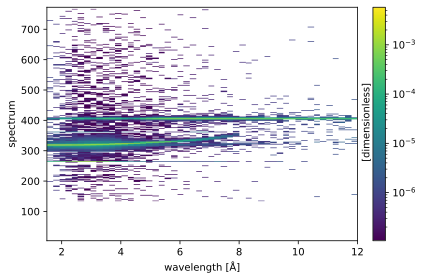

In [15]:
norm_wav.hist(wavelength=50).plot(norm='log')

A result of this is that we can see the transmission direct beam on the measurements (as mentioned above). 
Therefore, we want to create region of interest around the specular pixel, which is spectrum index 405.
We will make the region of interest 30 pixels wide. 

In [16]:
width = 15
specular_index = 405 

norm_wav_crop = norm_wav['spectrum', sc.index(specular_index-width): sc.index(specular_index+width)].copy()

Plotting this, gives a much more informative image. 

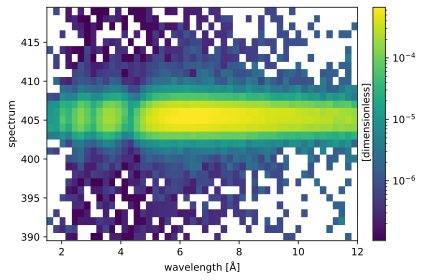

In [17]:
norm_wav_crop.hist(wavelength=50).plot(norm='log')

## Computing theta and Q

Again, we can use the reflectometry conversions to compute theta $\theta$, the angle of incidence.
To ensure that the necessary gravity correction is performed, we must create the `'gravity'` attribute. 

In [18]:
norm_wav_crop.attrs['gravity'] = sc.vector([0, -1, 0]) * sc.constants.g
norm_theta = reflectometry.conversions.wavelength_to_theta(norm_wav_crop, graph=graph)

This can then be used to compute the reflectivity as a function of the scattering vector $Q$. 

In [19]:
norm_q = reflectometry.conversions.theta_to_q(norm_theta, graph=graph)

Finally, we can plot the data as a function of a logarithmic $Q$ axis by histogramming in $Q$, summing over the spectrum dimension, and normalising by the bin width and interval.

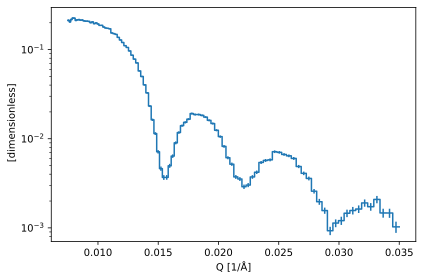

In [106]:
q_values = sc.geomspace('Q', start=0.0075, stop=0.035, num=100, unit=sc.Unit('1/Å'))
norm_q_bin = norm_q.hist(Q=q_values).sum('spectrum')
width = (qq[1:] - qq[:-1])
width /= qq[-1] - qq[0]
(norm_q_bin / width).plot(norm='log')